In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as neural_network
import torch.nn.functional as functions
import torchvision.transforms as transforms
import torch.nn as model
import torch.nn.functional as functions
import torch.optim as optim

from torchvision import datasets

- Defines a function to download the FashionMNIST dataset, setting it for training, ensuring download if not present, and applying a transformation to convert images to tensors.


In [2]:
def download_data_digits():
    return datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

train_data = download_data_digits()

100%|██████████| 26421880/26421880 [00:03<00:00, 6746691.06it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274713.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5045351.40it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11412408.56it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



- Configures a DataLoader to handle batching, shuffling, and loading data in parallel using multiple workers.


In [3]:
train = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=2)

The show_samples_test() function is defined to visualize samples from the training dataset. This helps in understanding the data better and ensures that the dataset has been loaded correctly.

In [7]:
def show_samples_test(length=10):
    # Creating an iterator from the train DataLoader
    data_iter = iter(train)
    
    # Using next() function to get the next batch
    images, labels = next(data_iter)
    
    # Converting tensors to numpy arrays if necessary for plotting
    images = images.numpy()

    # Plotting the images with matplotlib or similar library
    plt.figure(figsize=(10, 2))
    for i in range(length):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()


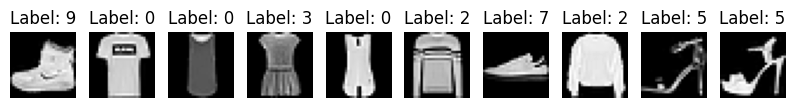

In [8]:
show_samples_test(10)

These cells define two crucial components of a GAN:
- *Discriminator*: A neural network that classifies images as real or fake. This model is trained to maximize the probability of correctly classifying a given input as real or fake.
- *Generator*: Another neural network that generates new images from a random noise vector. The generator is trained to maximize the probability of the discriminator making a mistake.


In [9]:
class Discriminator(neural_network.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.input_layer    = neural_network.Linear(784, 128)
        self.hidden_layer_1 = neural_network.Linear(128, 64)
        self.hidden_layer_2 = neural_network.Linear(64, 32)
        self.output_layer   = neural_network.Linear(32, 1)

        self.dropout = neural_network.Dropout(0.2)
        
        
    def forward(self, img_input):
        img_input = img_input.view(-1, 28 * 28)
        img_input = functions.leaky_relu(self.input_layer(img_input), 0.2) 
        img_input = self.dropout(img_input)
        img_input = functions.leaky_relu(self.hidden_layer_1(img_input), 0.2)
        img_input = self.dropout(img_input)
        img_input = functions.leaky_relu(self.hidden_layer_2(img_input), 0.2)
        img_input = self.dropout(img_input)
        
        return self.output_layer(img_input)

In [11]:
class Generator(neural_network.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.input_layer    =  neural_network.Linear(100, 32)
        self.hidden_layer_1 =  neural_network.Linear(32, 64)
        self.hidden_layer_2 =  neural_network.Linear(64, 128)
        self.output_layer   =  neural_network.Linear(128, 784)
        
        self.dropout = neural_network.Dropout(0.2)

    def forward(self, img_input):
        img_input = functions.leaky_relu(self.input_layer(img_input), 0.2)
        img_input = self.dropout(img_input)
        img_input = functions.leaky_relu(self.hidden_layer_1(img_input), 0.2)
        img_input = self.dropout(img_input)
        img_input = functions.leaky_relu(self.hidden_layer_2(img_input), 0.2)
        img_input = self.dropout(img_input)
        
        return functions.tanh(self.output_layer(img_input))

Here, instances of the Discriminator and Generator are created. The real_loss() function is defined to compute the loss for the discriminator, which measures how well it distinguishes real images from fake ones.


In [12]:
D = Discriminator()
G = Generator()

def real_loss(D_out):
    batch_size = D_out.size(0)
    criterion = neural_network.BCEWithLogitsLoss()
    return criterion(D_out.squeeze(), torch.ones(batch_size))
    

def fake_loss(D_out):
    criterion = neural_network.BCEWithLogitsLoss()
    return criterion(D_out.squeeze(), torch.zeros(D_out.size(0)))

d_optimizer = optim.Adam(D.parameters(), 0.002)
g_optimizer = optim.Adam(G.parameters(), 0.002)

The train_discriminator() function includes code to train the discriminator. It involves calculating the loss and updating the model parameters. This function is crucial for learning the parameters that correctly classify images as real or generated.


In [13]:
def train_discriminator(G, D, optimizer, real_data, batch_size, size):
    real_data = scale(real_data.view(batch_size, -1))

    optimizer.zero_grad()
    D.train()

    fake_data = G.forward(random_vector(batch_size, size))
    total_loss = real_loss(D.forward(real_data)) + fake_loss(D.forward(fake_data))
    total_loss.backward()
    optimizer.step()
    
    return total_loss

def train_generator(G, D, optimizer, batch_size, size):
    optimizer.zero_grad()
    G.train()
    fake_data = G.forward(random_vector(batch_size, size))
    loss = real_loss(D.forward(fake_data))
    loss.backward()
    optimizer.step()
    return loss

def random_vector(batch_size, lenx):
    return torch.randn(batch_size, lenx).float()

This function provides a way to visualize how the generator is performing during training by showing images it generates.


In [14]:
def show_training_sample(data):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4)
    for ax, img in zip(axes.flatten(), data[-1]):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()
    
    
def show_training_loss(d_loss_, g_loss):
    plt.plot(d_loss_arr, label="N.Discriminator", alpha=0.5)
    plt.plot(g_loss_arr, label="N.Generator", alpha=0.5)
    plt.title("Trainings loss")
    plt.legend()
    plt.show()

This cell likely contains the loop where training occurs over multiple epochs. It might include saving samples at each epoch using pickle, tracking the loss for analysis, and adjusting the models' parameters based on the computed gradients.


[1] -- discriminator_loss: 1.391111135482788  -- generator_loss: 0.689235270023346
[1] -- discriminator_loss: 1.2583423852920532  -- generator_loss: 0.688197910785675
[1] -- discriminator_loss: 1.4041389226913452  -- generator_loss: 1.1279709339141846
[1] -- discriminator_loss: 1.08856201171875  -- generator_loss: 0.9651371836662292
[1] -- discriminator_loss: 0.1151147112250328  -- generator_loss: 3.5079002380371094
[1] -- discriminator_loss: 0.5462297797203064  -- generator_loss: 2.6935269832611084
[1] -- discriminator_loss: 1.23544180393219  -- generator_loss: 0.5202699899673462
[1] -- discriminator_loss: 0.5647466778755188  -- generator_loss: 3.090815544128418
[1] -- discriminator_loss: 0.7882659435272217  -- generator_loss: 0.8673133254051208
[1] -- discriminator_loss: 0.44125646352767944  -- generator_loss: 3.173471450805664
[1] -- discriminator_loss: 0.4421873986721039  -- generator_loss: 9.727807998657227
[1] -- discriminator_loss: 0.724912703037262  -- generator_loss: 4.7824864

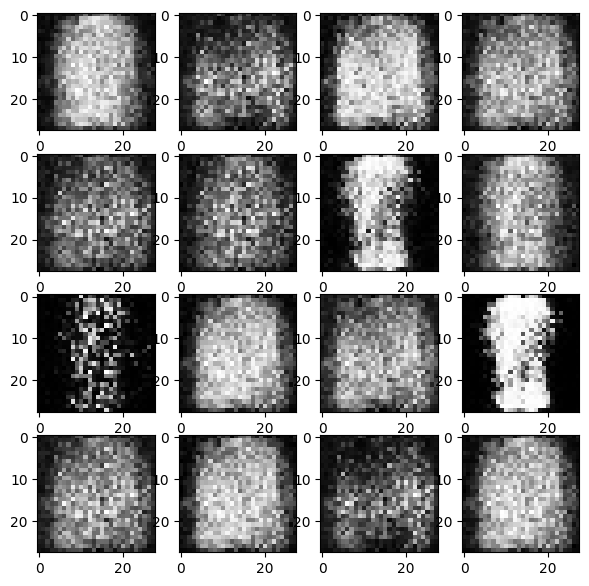

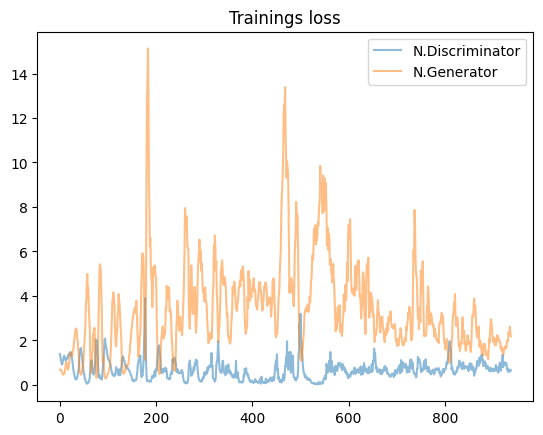

[2] -- discriminator_loss: 0.7198352813720703  -- generator_loss: 2.9748334884643555
[2] -- discriminator_loss: 0.5436630845069885  -- generator_loss: 2.577117443084717
[2] -- discriminator_loss: 0.8041694164276123  -- generator_loss: 2.6490166187286377
[2] -- discriminator_loss: 1.1049363613128662  -- generator_loss: 0.9893248081207275
[2] -- discriminator_loss: 0.9053592681884766  -- generator_loss: 2.1062417030334473
[2] -- discriminator_loss: 0.6611493229866028  -- generator_loss: 2.409445285797119
[2] -- discriminator_loss: 0.8466606140136719  -- generator_loss: 1.7882885932922363
[2] -- discriminator_loss: 0.8250336647033691  -- generator_loss: 2.4759907722473145
[2] -- discriminator_loss: 1.0122421979904175  -- generator_loss: 2.0936028957366943
[2] -- discriminator_loss: 0.8195836544036865  -- generator_loss: 2.8098042011260986
[2] -- discriminator_loss: 1.4722487926483154  -- generator_loss: 1.3795132637023926
[2] -- discriminator_loss: 0.7119734287261963  -- generator_loss: 1

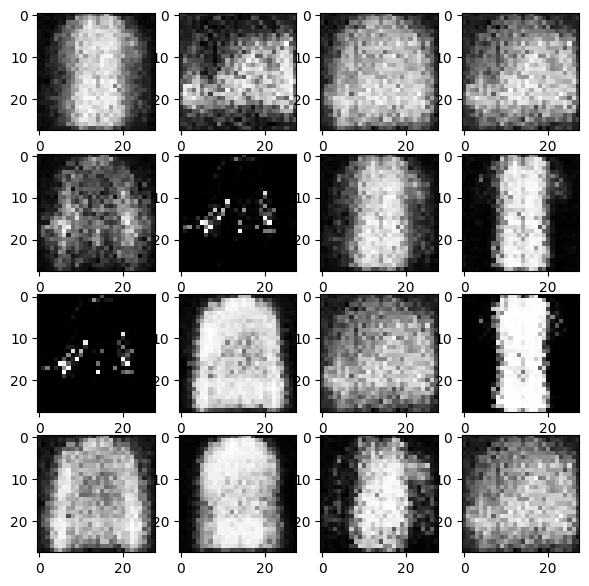

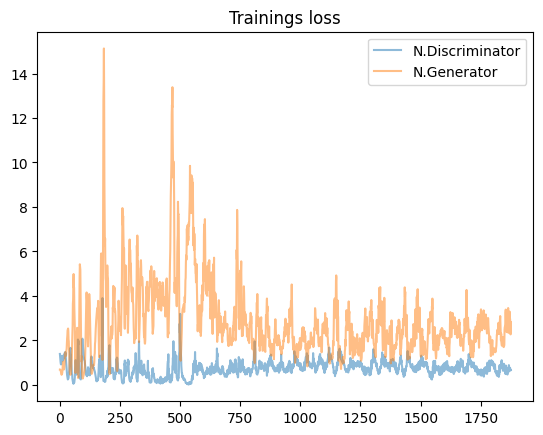

[3] -- discriminator_loss: 0.6918584108352661  -- generator_loss: 2.1561279296875
[3] -- discriminator_loss: 0.8454586267471313  -- generator_loss: 2.1719701290130615
[3] -- discriminator_loss: 0.6990878582000732  -- generator_loss: 2.172417640686035
[3] -- discriminator_loss: 0.7283165454864502  -- generator_loss: 1.973440408706665
[3] -- discriminator_loss: 0.7326879501342773  -- generator_loss: 1.5679175853729248
[3] -- discriminator_loss: 0.8672084212303162  -- generator_loss: 2.7061386108398438
[3] -- discriminator_loss: 0.781113862991333  -- generator_loss: 1.3655953407287598
[3] -- discriminator_loss: 0.9520567655563354  -- generator_loss: 1.8946410417556763
[3] -- discriminator_loss: 1.022700309753418  -- generator_loss: 1.4032844305038452
[3] -- discriminator_loss: 0.8604901432991028  -- generator_loss: 1.6038320064544678
[3] -- discriminator_loss: 0.7128726243972778  -- generator_loss: 1.4909420013427734
[3] -- discriminator_loss: 0.6821045875549316  -- generator_loss: 2.4638

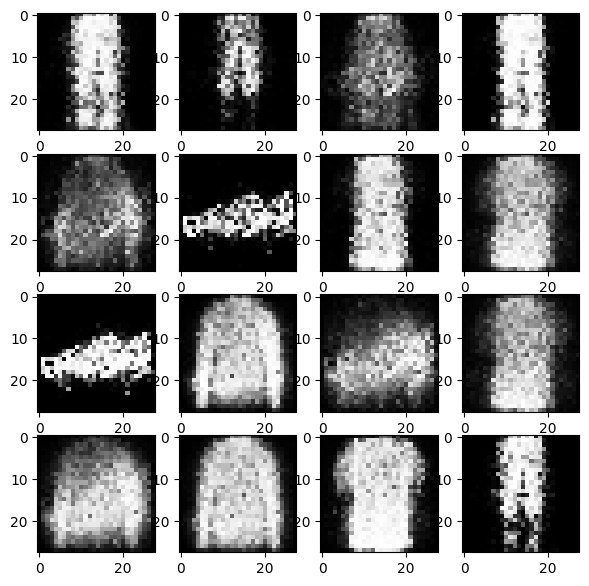

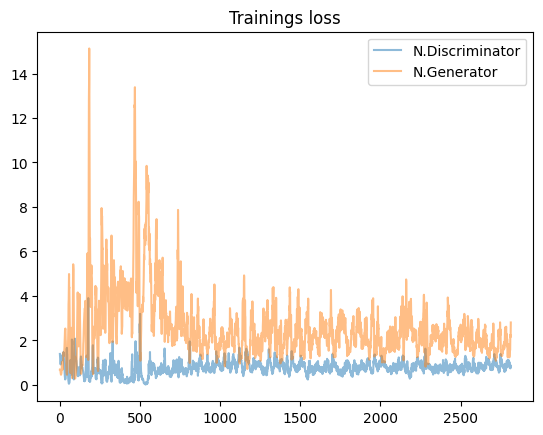

[4] -- discriminator_loss: 0.7125593423843384  -- generator_loss: 2.14203143119812
[4] -- discriminator_loss: 0.8276833295822144  -- generator_loss: 1.832756519317627
[4] -- discriminator_loss: 0.7802217602729797  -- generator_loss: 2.2646193504333496
[4] -- discriminator_loss: 0.9570736885070801  -- generator_loss: 1.9895812273025513
[4] -- discriminator_loss: 1.1119818687438965  -- generator_loss: 1.6265878677368164
[4] -- discriminator_loss: 0.728019654750824  -- generator_loss: 2.7276265621185303
[4] -- discriminator_loss: 0.8390239477157593  -- generator_loss: 1.70857834815979
[4] -- discriminator_loss: 0.8352617025375366  -- generator_loss: 1.7543162107467651
[4] -- discriminator_loss: 1.0563411712646484  -- generator_loss: 1.514931559562683
[4] -- discriminator_loss: 1.024593710899353  -- generator_loss: 1.8139169216156006
[4] -- discriminator_loss: 1.0079898834228516  -- generator_loss: 1.3380398750305176
[4] -- discriminator_loss: 0.7538589239120483  -- generator_loss: 1.77999

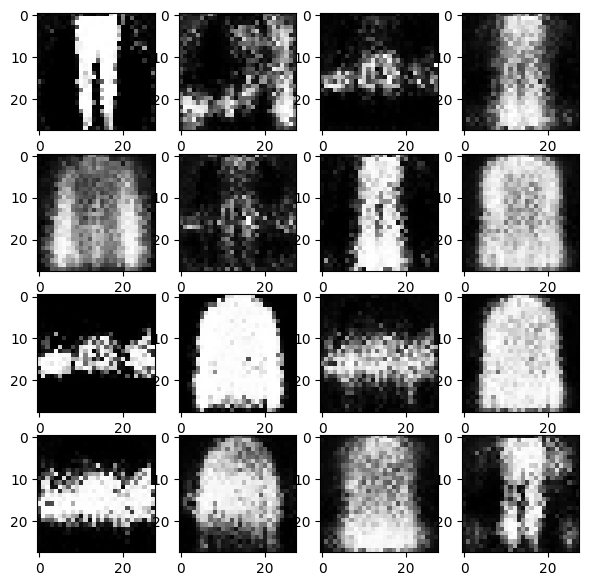

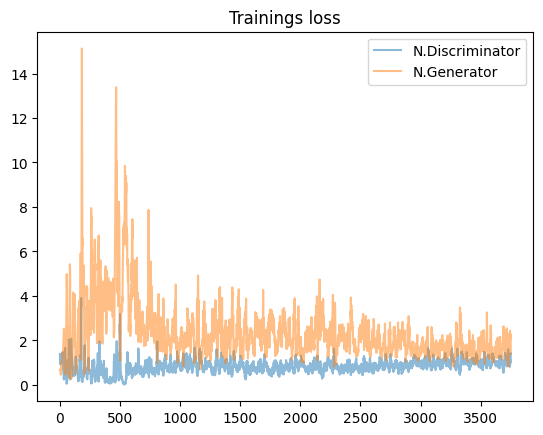

[5] -- discriminator_loss: 1.518477439880371  -- generator_loss: 1.1687631607055664
[5] -- discriminator_loss: 1.5570224523544312  -- generator_loss: 0.9831273555755615
[5] -- discriminator_loss: 0.8952762484550476  -- generator_loss: 3.014888286590576
[5] -- discriminator_loss: 1.0012304782867432  -- generator_loss: 1.4960589408874512
[5] -- discriminator_loss: 1.1577954292297363  -- generator_loss: 1.6413688659667969
[5] -- discriminator_loss: 0.85945725440979  -- generator_loss: 2.1648216247558594
[5] -- discriminator_loss: 1.134364128112793  -- generator_loss: 1.2836968898773193
[5] -- discriminator_loss: 0.8433892726898193  -- generator_loss: 2.1808481216430664
[5] -- discriminator_loss: 0.969508707523346  -- generator_loss: 1.7978837490081787
[5] -- discriminator_loss: 1.416926622390747  -- generator_loss: 2.0433619022369385
[5] -- discriminator_loss: 0.8399695754051208  -- generator_loss: 1.3801615238189697
[5] -- discriminator_loss: 0.840538501739502  -- generator_loss: 1.78716

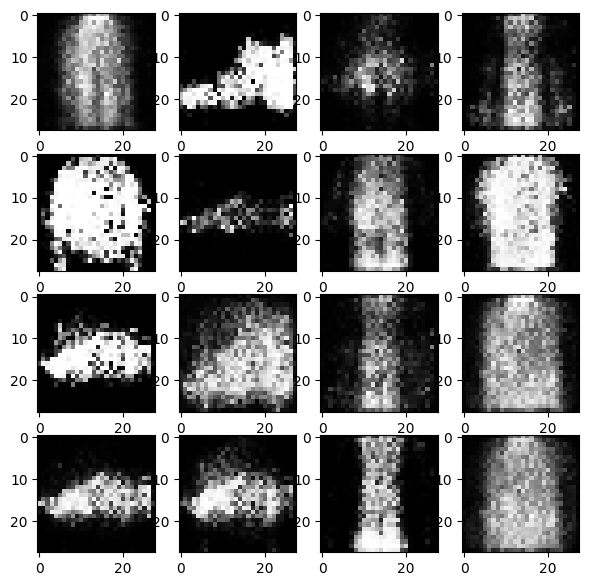

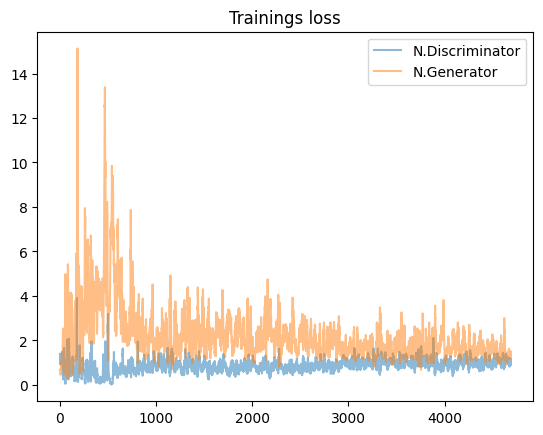

[6] -- discriminator_loss: 0.918280839920044  -- generator_loss: 1.3573588132858276
[6] -- discriminator_loss: 1.029903531074524  -- generator_loss: 1.312190294265747
[6] -- discriminator_loss: 1.281165599822998  -- generator_loss: 1.3154242038726807
[6] -- discriminator_loss: 1.1214519739151  -- generator_loss: 1.3161038160324097
[6] -- discriminator_loss: 1.0668840408325195  -- generator_loss: 1.0827958583831787
[6] -- discriminator_loss: 1.1327040195465088  -- generator_loss: 1.0535786151885986
[6] -- discriminator_loss: 1.0774646997451782  -- generator_loss: 1.2362059354782104
[6] -- discriminator_loss: 1.0176469087600708  -- generator_loss: 1.374108910560608
[6] -- discriminator_loss: 1.0356820821762085  -- generator_loss: 1.5423752069473267
[6] -- discriminator_loss: 1.1270027160644531  -- generator_loss: 1.6270573139190674
[6] -- discriminator_loss: 1.0961384773254395  -- generator_loss: 1.8676729202270508
[6] -- discriminator_loss: 0.9685304164886475  -- generator_loss: 1.41127

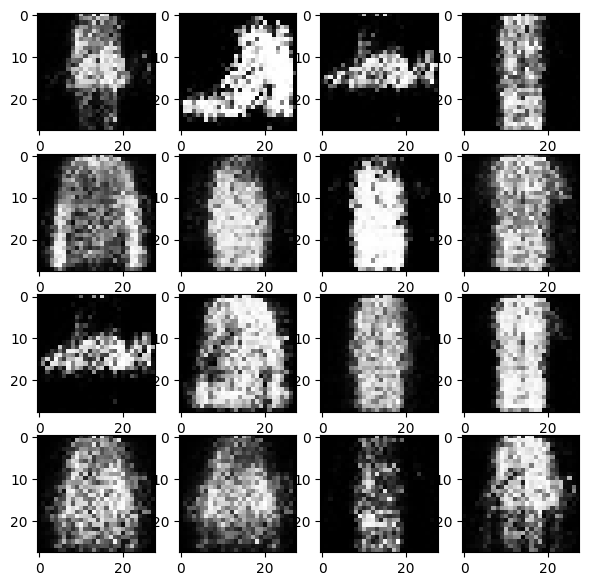

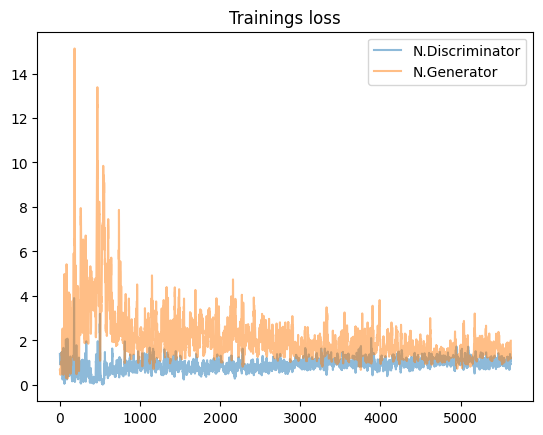

[7] -- discriminator_loss: 0.8691527843475342  -- generator_loss: 1.4002057313919067
[7] -- discriminator_loss: 1.031835913658142  -- generator_loss: 1.425568699836731
[7] -- discriminator_loss: 1.119482159614563  -- generator_loss: 1.6707367897033691
[7] -- discriminator_loss: 1.134001612663269  -- generator_loss: 1.5739611387252808
[7] -- discriminator_loss: 0.9128619432449341  -- generator_loss: 1.6479511260986328
[7] -- discriminator_loss: 1.1759872436523438  -- generator_loss: 0.9238179922103882
[7] -- discriminator_loss: 1.072372555732727  -- generator_loss: 1.1666696071624756
[7] -- discriminator_loss: 0.9938231706619263  -- generator_loss: 1.2097949981689453
[7] -- discriminator_loss: 0.9173702001571655  -- generator_loss: 1.72822904586792
[7] -- discriminator_loss: 1.3849400281906128  -- generator_loss: 1.3951550722122192
[7] -- discriminator_loss: 1.171832799911499  -- generator_loss: 1.010638952255249
[7] -- discriminator_loss: 1.1826481819152832  -- generator_loss: 2.105726

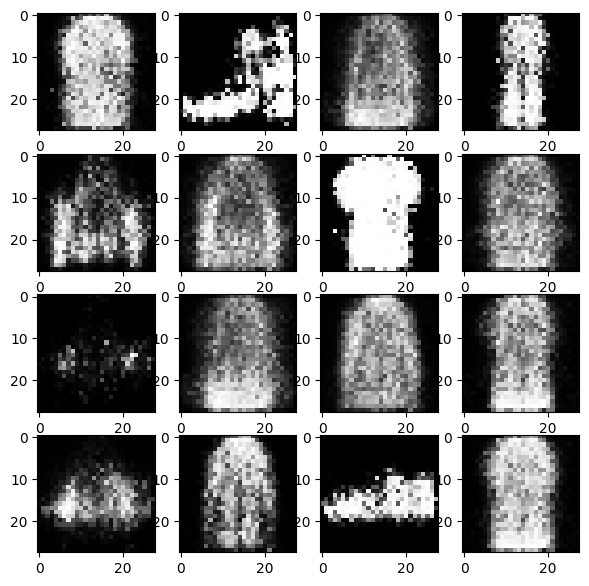

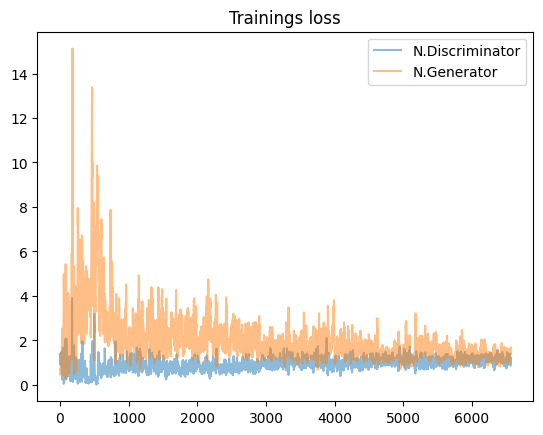

[8] -- discriminator_loss: 1.1444501876831055  -- generator_loss: 1.3638197183609009
[8] -- discriminator_loss: 1.3090887069702148  -- generator_loss: 1.3613388538360596
[8] -- discriminator_loss: 1.3074564933776855  -- generator_loss: 0.8185845613479614
[8] -- discriminator_loss: 1.2522507905960083  -- generator_loss: 1.1637001037597656
[8] -- discriminator_loss: 1.3980379104614258  -- generator_loss: 1.3574199676513672
[8] -- discriminator_loss: 1.2421091794967651  -- generator_loss: 1.301983118057251
[8] -- discriminator_loss: 1.127403736114502  -- generator_loss: 1.4081703424453735
[8] -- discriminator_loss: 1.2545957565307617  -- generator_loss: 1.2580687999725342
[8] -- discriminator_loss: 1.321457862854004  -- generator_loss: 0.9698354005813599
[8] -- discriminator_loss: 1.0651882886886597  -- generator_loss: 1.0638455152511597
[8] -- discriminator_loss: 1.0507805347442627  -- generator_loss: 1.1157013177871704
[8] -- discriminator_loss: 1.197771668434143  -- generator_loss: 1.3

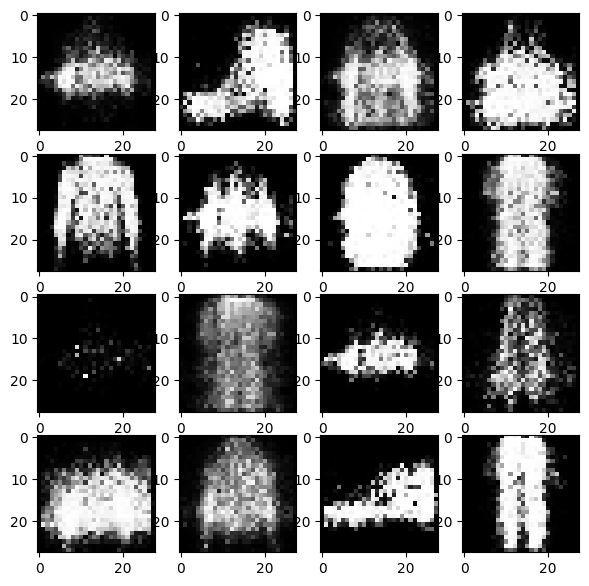

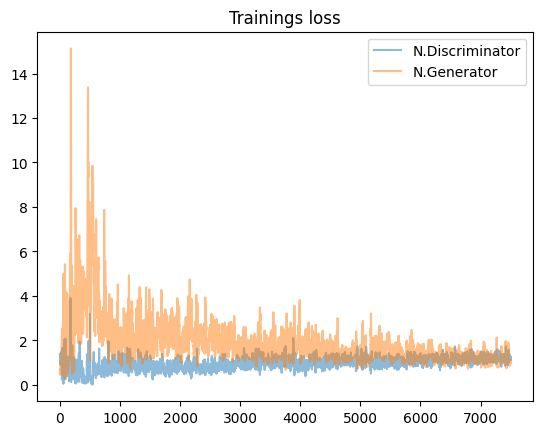

[9] -- discriminator_loss: 1.1284624338150024  -- generator_loss: 1.1785966157913208
[9] -- discriminator_loss: 1.137953758239746  -- generator_loss: 1.1541763544082642
[9] -- discriminator_loss: 1.0089199542999268  -- generator_loss: 1.2174701690673828
[9] -- discriminator_loss: 1.509066104888916  -- generator_loss: 1.2392024993896484
[9] -- discriminator_loss: 1.144234538078308  -- generator_loss: 0.9382365942001343
[9] -- discriminator_loss: 1.0712369680404663  -- generator_loss: 1.0227878093719482
[9] -- discriminator_loss: 0.9587347507476807  -- generator_loss: 1.7692224979400635
[9] -- discriminator_loss: 1.1429805755615234  -- generator_loss: 1.081023097038269
[9] -- discriminator_loss: 1.0870088338851929  -- generator_loss: 1.1603649854660034
[9] -- discriminator_loss: 1.2518634796142578  -- generator_loss: 1.0494545698165894
[9] -- discriminator_loss: 1.1256192922592163  -- generator_loss: 0.9960081577301025
[9] -- discriminator_loss: 0.9400526285171509  -- generator_loss: 1.5

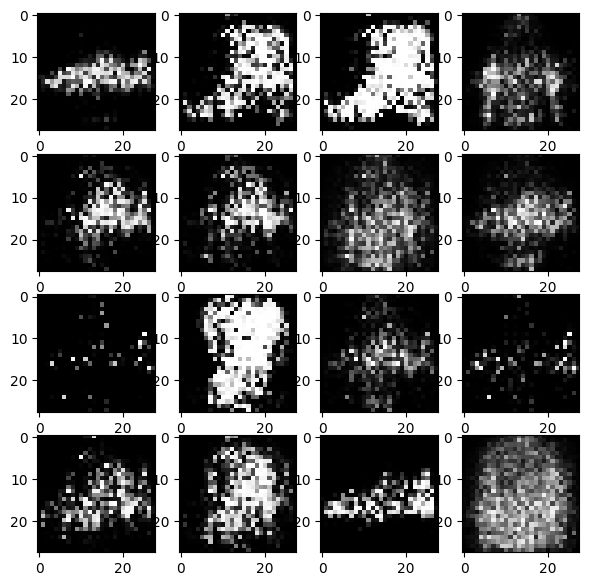

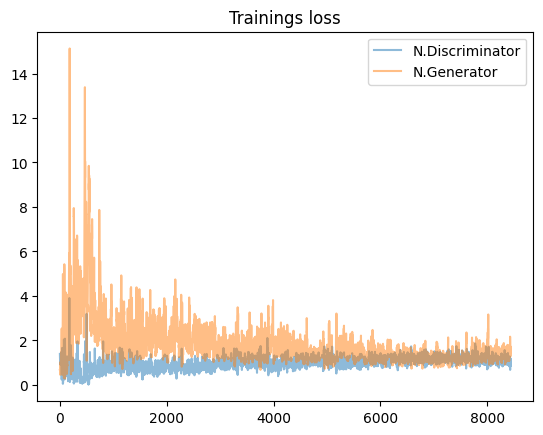

[10] -- discriminator_loss: 1.215156078338623  -- generator_loss: 1.586833119392395
[10] -- discriminator_loss: 0.8690841197967529  -- generator_loss: 1.770823359489441
[10] -- discriminator_loss: 1.5297085046768188  -- generator_loss: 1.3606412410736084
[10] -- discriminator_loss: 0.8949057459831238  -- generator_loss: 1.5712331533432007
[10] -- discriminator_loss: 0.918705940246582  -- generator_loss: 1.2493003606796265
[10] -- discriminator_loss: 1.1109931468963623  -- generator_loss: 0.9054129123687744
[10] -- discriminator_loss: 1.3481372594833374  -- generator_loss: 1.1266162395477295
[10] -- discriminator_loss: 1.03084135055542  -- generator_loss: 1.272304654121399
[10] -- discriminator_loss: 1.02557373046875  -- generator_loss: 1.4256064891815186
[10] -- discriminator_loss: 1.3774499893188477  -- generator_loss: 1.3393287658691406
[10] -- discriminator_loss: 0.9691744446754456  -- generator_loss: 1.446744441986084
[10] -- discriminator_loss: 1.2550822496414185  -- generator_los

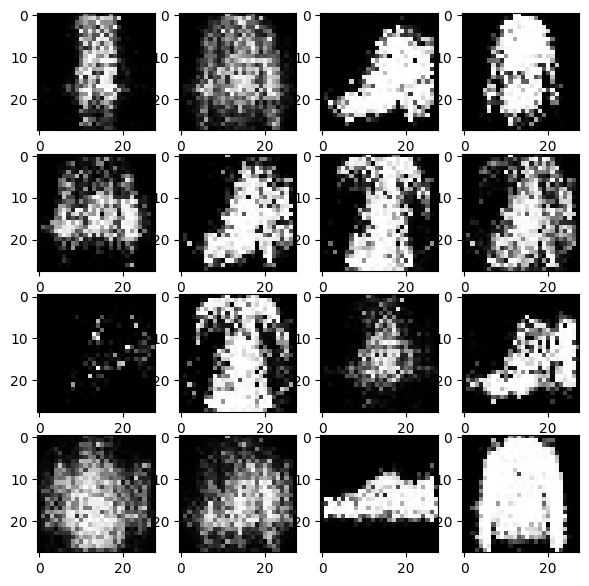

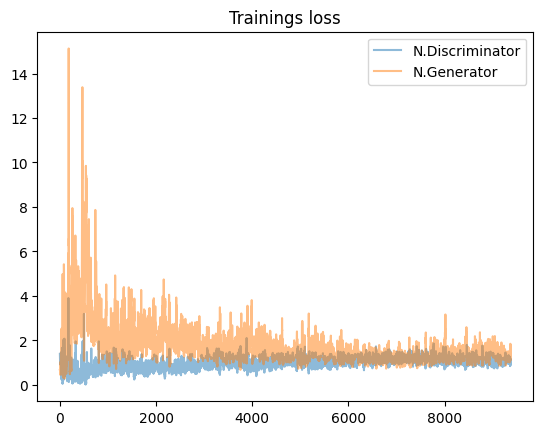

[11] -- discriminator_loss: 1.174670696258545  -- generator_loss: 1.543470859527588
[11] -- discriminator_loss: 0.9781769514083862  -- generator_loss: 1.3640987873077393
[11] -- discriminator_loss: 1.0918278694152832  -- generator_loss: 1.3412456512451172
[11] -- discriminator_loss: 1.0700843334197998  -- generator_loss: 1.3727434873580933
[11] -- discriminator_loss: 1.1037523746490479  -- generator_loss: 1.2184581756591797
[11] -- discriminator_loss: 1.1889870166778564  -- generator_loss: 1.4957503080368042
[11] -- discriminator_loss: 1.0119963884353638  -- generator_loss: 1.1412208080291748
[11] -- discriminator_loss: 1.1297118663787842  -- generator_loss: 1.564631462097168
[11] -- discriminator_loss: 1.0454342365264893  -- generator_loss: 1.6583125591278076
[11] -- discriminator_loss: 1.114409327507019  -- generator_loss: 1.3174554109573364
[11] -- discriminator_loss: 1.2264602184295654  -- generator_loss: 1.0148273706436157
[11] -- discriminator_loss: 0.9698945879936218  -- generat

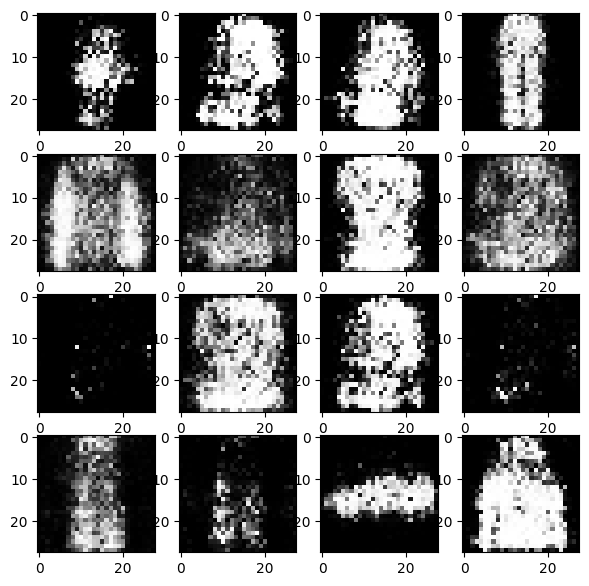

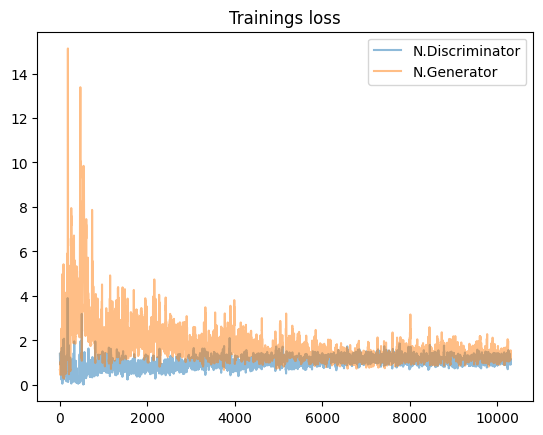

[12] -- discriminator_loss: 1.213463306427002  -- generator_loss: 1.3342869281768799
[12] -- discriminator_loss: 1.0592825412750244  -- generator_loss: 1.5078907012939453
[12] -- discriminator_loss: 1.348196029663086  -- generator_loss: 0.9955652356147766
[12] -- discriminator_loss: 1.1868780851364136  -- generator_loss: 0.9734681844711304
[12] -- discriminator_loss: 1.1327276229858398  -- generator_loss: 0.9454221725463867
[12] -- discriminator_loss: 1.2305834293365479  -- generator_loss: 1.2379050254821777
[12] -- discriminator_loss: 0.9351909160614014  -- generator_loss: 1.6295738220214844
[12] -- discriminator_loss: 1.2759664058685303  -- generator_loss: 1.2400764226913452
[12] -- discriminator_loss: 1.2179845571517944  -- generator_loss: 1.1488474607467651
[12] -- discriminator_loss: 1.1497989892959595  -- generator_loss: 1.265526533126831
[12] -- discriminator_loss: 1.0735933780670166  -- generator_loss: 1.349470615386963
[12] -- discriminator_loss: 1.0327070951461792  -- generat

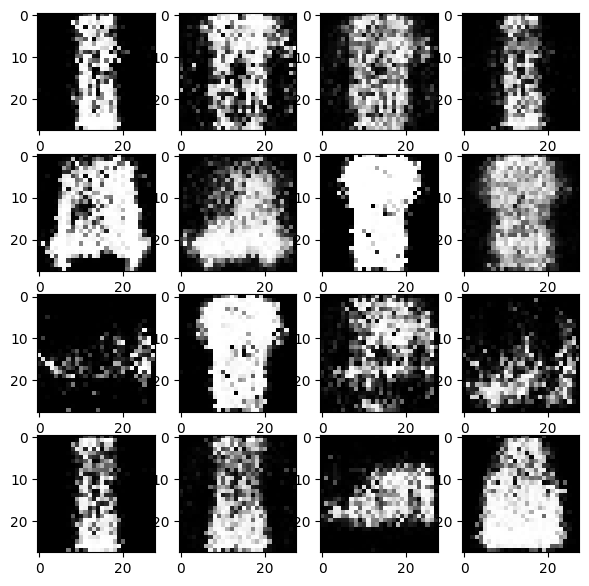

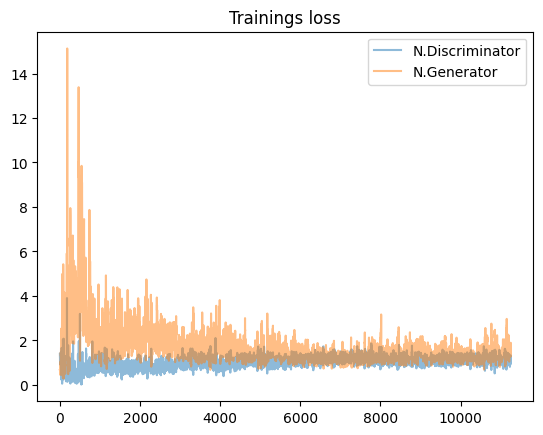

[13] -- discriminator_loss: 1.1989914178848267  -- generator_loss: 1.3306046724319458
[13] -- discriminator_loss: 1.0483224391937256  -- generator_loss: 1.1202867031097412
[13] -- discriminator_loss: 1.1961359977722168  -- generator_loss: 1.27023184299469
[13] -- discriminator_loss: 0.9523425102233887  -- generator_loss: 1.5765001773834229
[13] -- discriminator_loss: 0.9652785658836365  -- generator_loss: 1.3648722171783447
[13] -- discriminator_loss: 1.1586418151855469  -- generator_loss: 1.861242413520813
[13] -- discriminator_loss: 1.1403896808624268  -- generator_loss: 1.3420571088790894
[13] -- discriminator_loss: 1.2216758728027344  -- generator_loss: 1.2740747928619385
[13] -- discriminator_loss: 1.0778151750564575  -- generator_loss: 1.0463212728500366
[13] -- discriminator_loss: 0.9473894834518433  -- generator_loss: 1.2614227533340454
[13] -- discriminator_loss: 1.2092795372009277  -- generator_loss: 1.2131699323654175
[13] -- discriminator_loss: 1.1239089965820312  -- genera

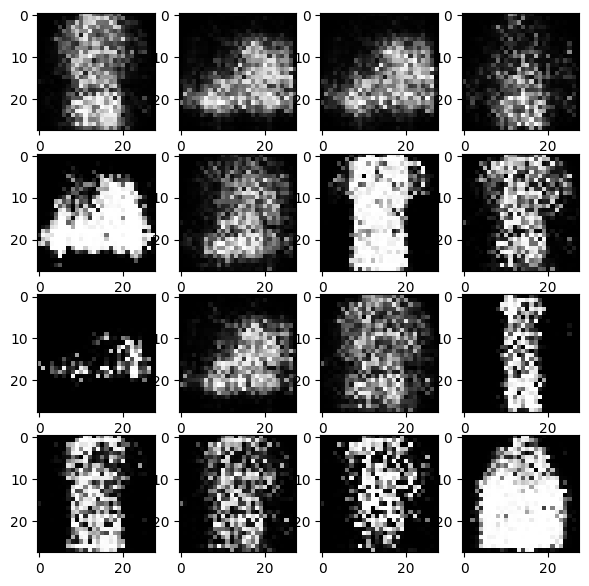

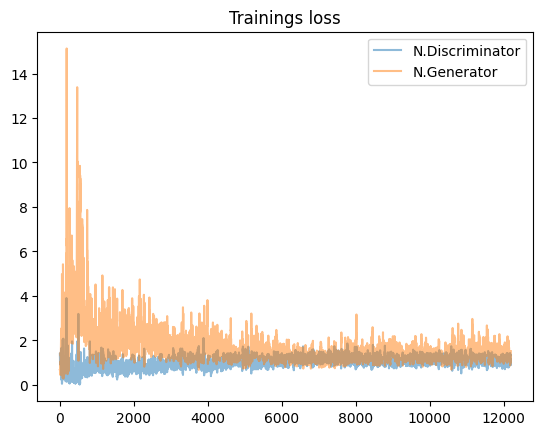

[14] -- discriminator_loss: 1.0166730880737305  -- generator_loss: 1.3321940898895264
[14] -- discriminator_loss: 1.0406790971755981  -- generator_loss: 1.402185320854187
[14] -- discriminator_loss: 1.3111414909362793  -- generator_loss: 1.1412744522094727
[14] -- discriminator_loss: 0.8389778733253479  -- generator_loss: 1.6103178262710571
[14] -- discriminator_loss: 1.1467512845993042  -- generator_loss: 1.2429819107055664
[14] -- discriminator_loss: 1.09624445438385  -- generator_loss: 1.990034818649292
[14] -- discriminator_loss: 0.9449516534805298  -- generator_loss: 1.2899556159973145
[14] -- discriminator_loss: 0.7174258828163147  -- generator_loss: 1.7372956275939941
[14] -- discriminator_loss: 1.364508867263794  -- generator_loss: 1.281036138534546
[14] -- discriminator_loss: 1.1207977533340454  -- generator_loss: 1.4724065065383911
[14] -- discriminator_loss: 0.8960252404212952  -- generator_loss: 1.1710128784179688
[14] -- discriminator_loss: 0.9232796430587769  -- generator

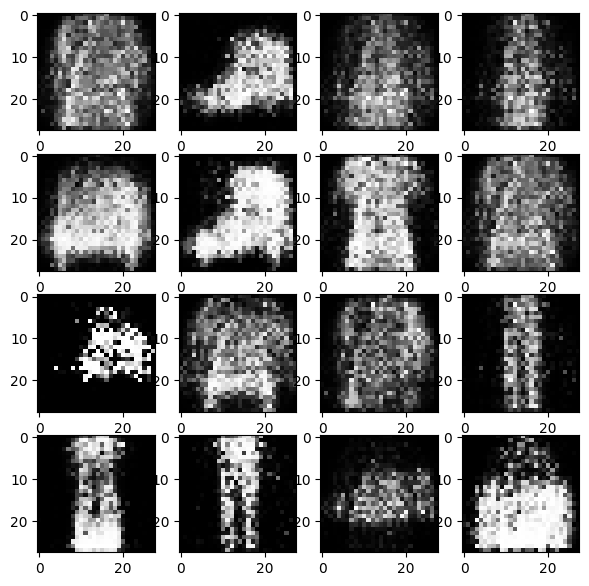

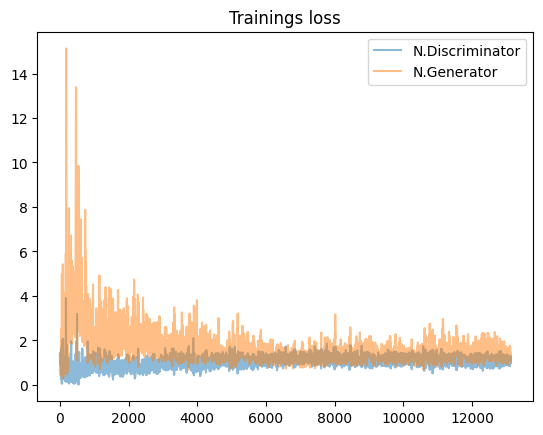

[15] -- discriminator_loss: 1.096882939338684  -- generator_loss: 1.1739915609359741
[15] -- discriminator_loss: 1.1319005489349365  -- generator_loss: 1.3042879104614258
[15] -- discriminator_loss: 1.1283023357391357  -- generator_loss: 1.031410574913025
[15] -- discriminator_loss: 1.0429550409317017  -- generator_loss: 1.7111446857452393
[15] -- discriminator_loss: 1.2518771886825562  -- generator_loss: 1.13480806350708
[15] -- discriminator_loss: 1.007875680923462  -- generator_loss: 1.825652003288269
[15] -- discriminator_loss: 1.1952184438705444  -- generator_loss: 1.4518712759017944
[15] -- discriminator_loss: 1.3993442058563232  -- generator_loss: 1.3867132663726807
[15] -- discriminator_loss: 1.3414981365203857  -- generator_loss: 1.3245793581008911
[15] -- discriminator_loss: 1.1364128589630127  -- generator_loss: 1.3974425792694092
[15] -- discriminator_loss: 1.211257815361023  -- generator_loss: 1.1568199396133423
[15] -- discriminator_loss: 1.0212831497192383  -- generator_

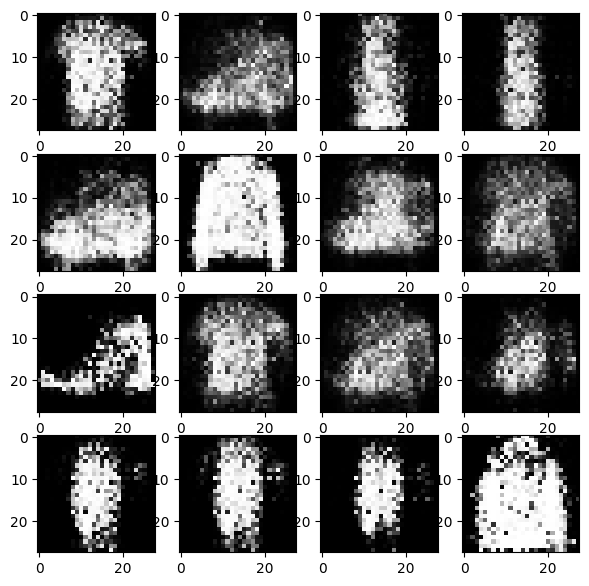

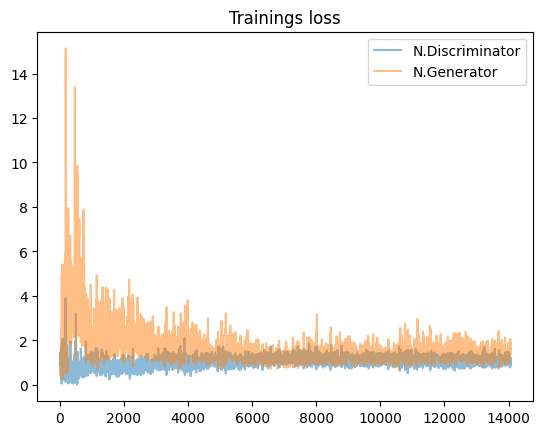

[16] -- discriminator_loss: 1.1794049739837646  -- generator_loss: 1.8203883171081543
[16] -- discriminator_loss: 1.2339997291564941  -- generator_loss: 1.5815099477767944
[16] -- discriminator_loss: 1.3405952453613281  -- generator_loss: 1.0134717226028442
[16] -- discriminator_loss: 1.237236738204956  -- generator_loss: 1.8526177406311035
[16] -- discriminator_loss: 0.7610217928886414  -- generator_loss: 1.3618237972259521
[16] -- discriminator_loss: 1.178555965423584  -- generator_loss: 1.6766855716705322
[16] -- discriminator_loss: 1.1259028911590576  -- generator_loss: 0.9337085485458374
[16] -- discriminator_loss: 1.1525912284851074  -- generator_loss: 1.4402271509170532
[16] -- discriminator_loss: 0.7886976599693298  -- generator_loss: 1.6341407299041748
[16] -- discriminator_loss: 1.283897876739502  -- generator_loss: 1.2044317722320557
[16] -- discriminator_loss: 0.8674027919769287  -- generator_loss: 1.5335516929626465
[16] -- discriminator_loss: 1.6417791843414307  -- genera

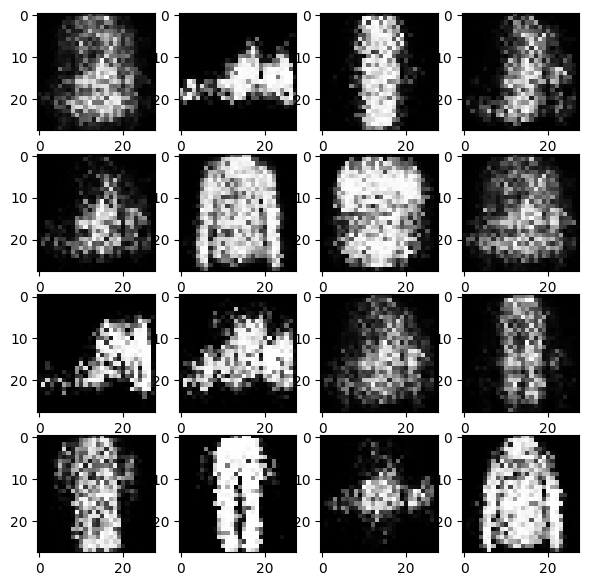

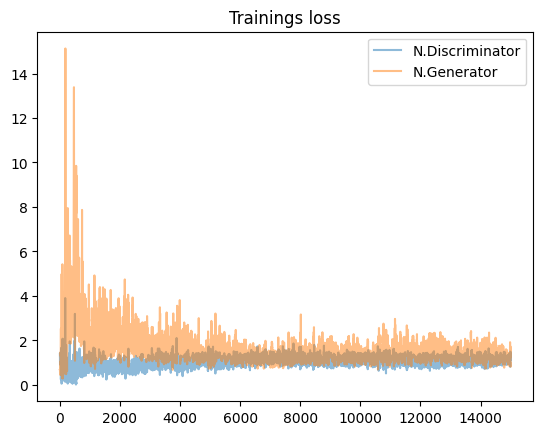

[17] -- discriminator_loss: 1.3806947469711304  -- generator_loss: 0.8815868496894836
[17] -- discriminator_loss: 1.330188274383545  -- generator_loss: 0.9837769269943237
[17] -- discriminator_loss: 1.005373477935791  -- generator_loss: 1.1697946786880493
[17] -- discriminator_loss: 1.1566470861434937  -- generator_loss: 1.5367183685302734
[17] -- discriminator_loss: 1.1934378147125244  -- generator_loss: 1.605232834815979
[17] -- discriminator_loss: 1.3355116844177246  -- generator_loss: 0.8243440985679626
[17] -- discriminator_loss: 1.37577223777771  -- generator_loss: 0.9203012585639954
[17] -- discriminator_loss: 1.1283899545669556  -- generator_loss: 1.4837512969970703
[17] -- discriminator_loss: 1.2909839153289795  -- generator_loss: 1.0673823356628418
[17] -- discriminator_loss: 0.9473767280578613  -- generator_loss: 1.3357549905776978
[17] -- discriminator_loss: 0.9782158732414246  -- generator_loss: 1.5143532752990723
[17] -- discriminator_loss: 1.1430442333221436  -- generato

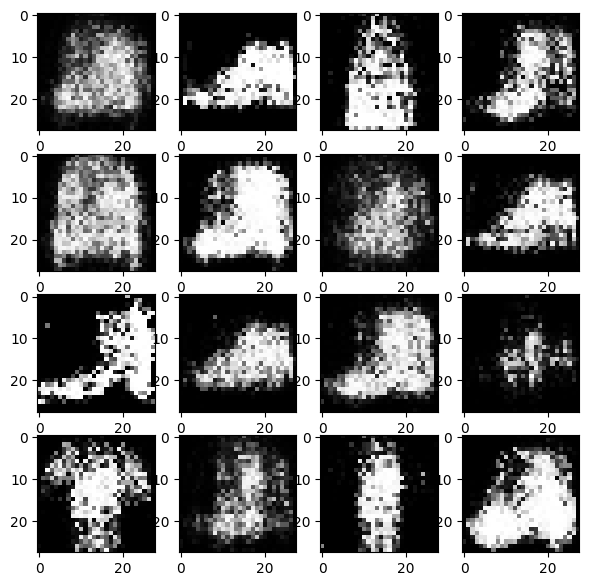

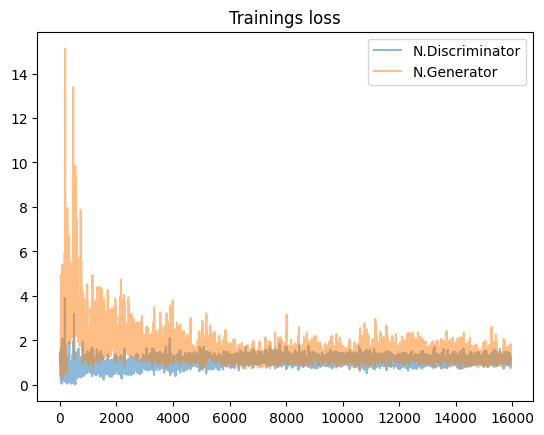

[18] -- discriminator_loss: 1.0416936874389648  -- generator_loss: 1.4721221923828125
[18] -- discriminator_loss: 1.271698236465454  -- generator_loss: 1.4008504152297974
[18] -- discriminator_loss: 1.140981674194336  -- generator_loss: 1.0830426216125488
[18] -- discriminator_loss: 0.9670568108558655  -- generator_loss: 1.1505341529846191
[18] -- discriminator_loss: 1.2240445613861084  -- generator_loss: 1.242577075958252
[18] -- discriminator_loss: 1.2083595991134644  -- generator_loss: 1.1589593887329102
[18] -- discriminator_loss: 1.0025891065597534  -- generator_loss: 1.2576793432235718
[18] -- discriminator_loss: 1.1164629459381104  -- generator_loss: 1.4522136449813843
[18] -- discriminator_loss: 1.2362475395202637  -- generator_loss: 1.5914119482040405
[18] -- discriminator_loss: 1.175312876701355  -- generator_loss: 1.0324642658233643
[18] -- discriminator_loss: 1.4268276691436768  -- generator_loss: 1.1071484088897705
[18] -- discriminator_loss: 1.309319019317627  -- generato

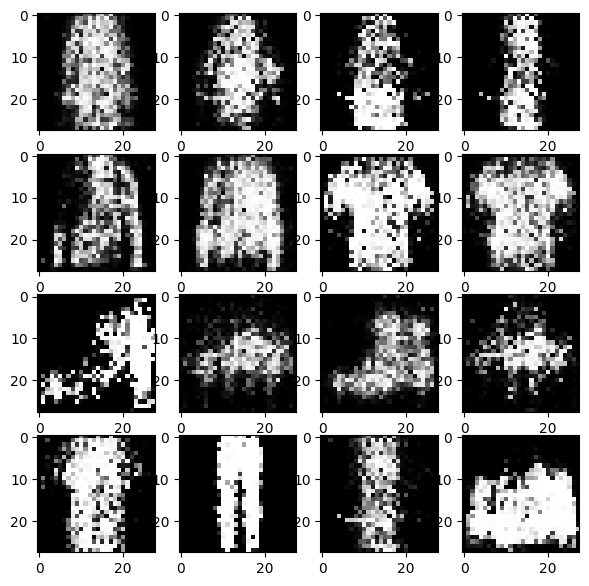

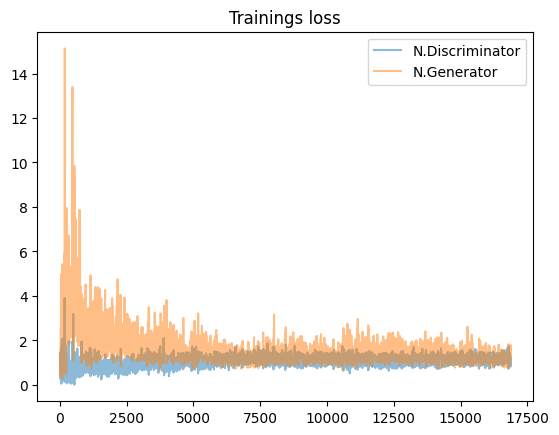

[19] -- discriminator_loss: 1.1305443048477173  -- generator_loss: 1.5232086181640625
[19] -- discriminator_loss: 1.1485557556152344  -- generator_loss: 1.3299963474273682
[19] -- discriminator_loss: 1.0417370796203613  -- generator_loss: 1.2812225818634033
[19] -- discriminator_loss: 1.3953202962875366  -- generator_loss: 1.3768614530563354
[19] -- discriminator_loss: 1.1618053913116455  -- generator_loss: 1.1412005424499512
[19] -- discriminator_loss: 1.127925992012024  -- generator_loss: 1.225630760192871
[19] -- discriminator_loss: 1.180816411972046  -- generator_loss: 1.2432031631469727
[19] -- discriminator_loss: 1.2881884574890137  -- generator_loss: 0.9437074661254883
[19] -- discriminator_loss: 1.2962255477905273  -- generator_loss: 1.1819069385528564
[19] -- discriminator_loss: 1.178807258605957  -- generator_loss: 0.8983364105224609
[19] -- discriminator_loss: 1.1295342445373535  -- generator_loss: 1.3636419773101807
[19] -- discriminator_loss: 1.104576587677002  -- generato

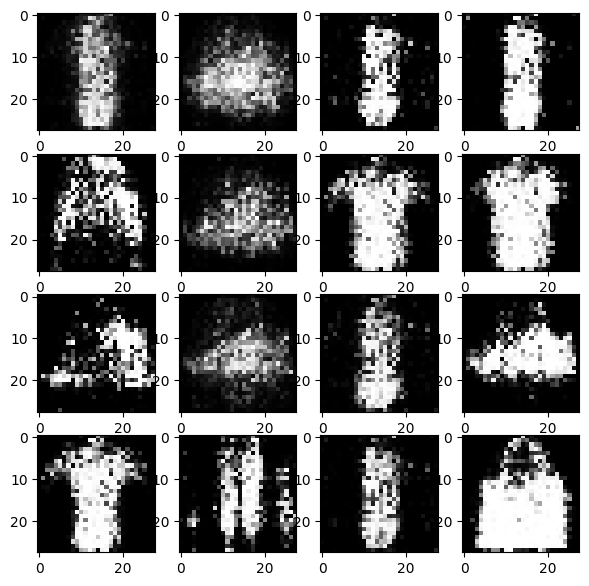

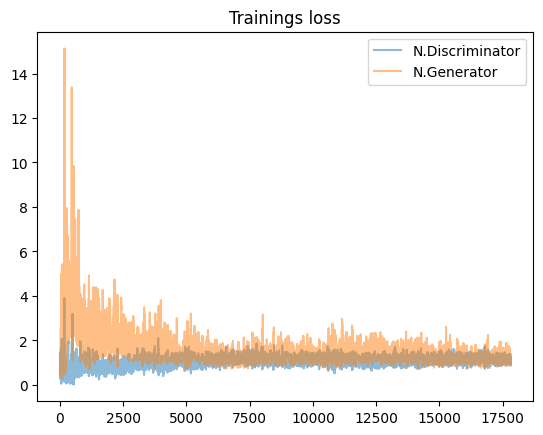

[20] -- discriminator_loss: 1.2311346530914307  -- generator_loss: 1.2593400478363037
[20] -- discriminator_loss: 1.103901743888855  -- generator_loss: 1.2228316068649292
[20] -- discriminator_loss: 1.014863133430481  -- generator_loss: 1.215463638305664
[20] -- discriminator_loss: 1.1576738357543945  -- generator_loss: 1.1956701278686523
[20] -- discriminator_loss: 1.2784624099731445  -- generator_loss: 1.121299147605896
[20] -- discriminator_loss: 1.1550408601760864  -- generator_loss: 1.0111126899719238
[20] -- discriminator_loss: 1.2531384229660034  -- generator_loss: 1.2552504539489746
[20] -- discriminator_loss: 1.1503477096557617  -- generator_loss: 0.92315274477005
[20] -- discriminator_loss: 1.1286976337432861  -- generator_loss: 1.1650125980377197
[20] -- discriminator_loss: 1.0249550342559814  -- generator_loss: 1.332458257675171
[20] -- discriminator_loss: 1.2916004657745361  -- generator_loss: 0.9900065660476685
[20] -- discriminator_loss: 1.1929771900177002  -- generator_

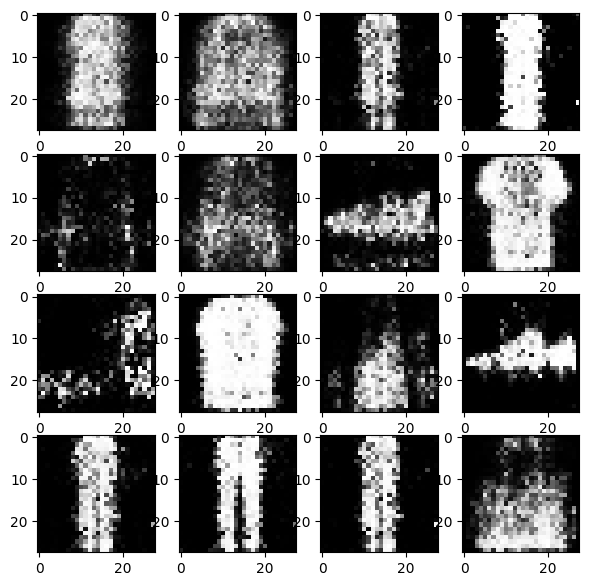

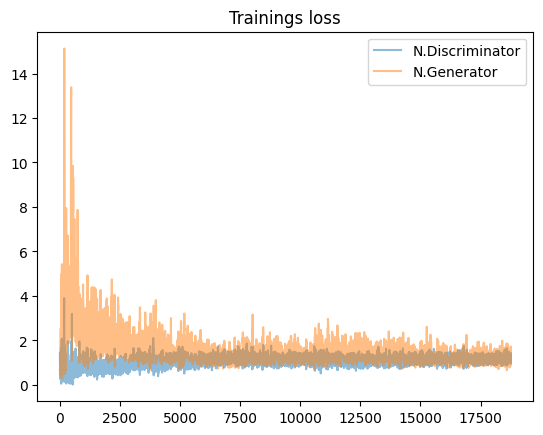

[21] -- discriminator_loss: 1.2794826030731201  -- generator_loss: 1.1183022260665894
[21] -- discriminator_loss: 1.267588496208191  -- generator_loss: 1.0890752077102661
[21] -- discriminator_loss: 1.0144202709197998  -- generator_loss: 1.1206047534942627
[21] -- discriminator_loss: 1.5325708389282227  -- generator_loss: 1.13579261302948
[21] -- discriminator_loss: 1.055243968963623  -- generator_loss: 1.026265263557434
[21] -- discriminator_loss: 1.0899543762207031  -- generator_loss: 1.124245285987854
[21] -- discriminator_loss: 1.4215418100357056  -- generator_loss: 1.1604524850845337
[21] -- discriminator_loss: 1.0992788076400757  -- generator_loss: 1.4124542474746704
[21] -- discriminator_loss: 1.321916103363037  -- generator_loss: 1.1078873872756958
[21] -- discriminator_loss: 1.2036769390106201  -- generator_loss: 1.1860154867172241
[21] -- discriminator_loss: 1.040567398071289  -- generator_loss: 1.3282569646835327
[21] -- discriminator_loss: 1.2524752616882324  -- generator_l

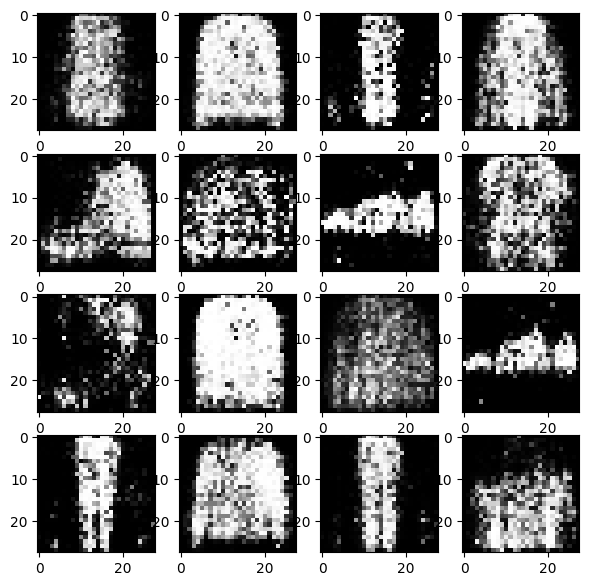

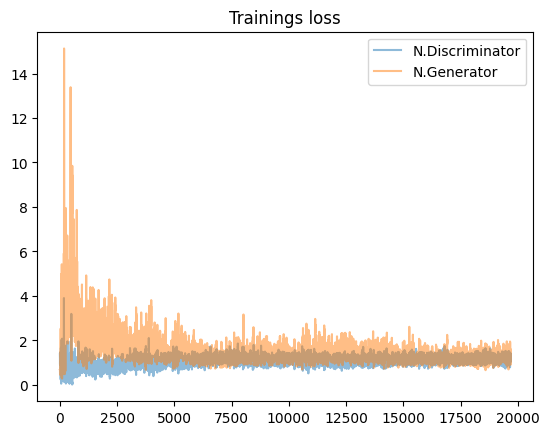

[22] -- discriminator_loss: 1.1950817108154297  -- generator_loss: 1.0056325197219849
[22] -- discriminator_loss: 1.283385992050171  -- generator_loss: 1.0613915920257568
[22] -- discriminator_loss: 1.0908138751983643  -- generator_loss: 1.253892421722412
[22] -- discriminator_loss: 1.2594449520111084  -- generator_loss: 1.165433645248413
[22] -- discriminator_loss: 1.1060984134674072  -- generator_loss: 1.0910735130310059
[22] -- discriminator_loss: 1.0534777641296387  -- generator_loss: 1.3177286386489868
[22] -- discriminator_loss: 1.4344074726104736  -- generator_loss: 1.5046573877334595
[22] -- discriminator_loss: 0.9804549813270569  -- generator_loss: 1.2223598957061768
[22] -- discriminator_loss: 1.4219114780426025  -- generator_loss: 1.056973934173584
[22] -- discriminator_loss: 1.2522785663604736  -- generator_loss: 1.0928092002868652
[22] -- discriminator_loss: 1.1730468273162842  -- generator_loss: 1.104546070098877
[22] -- discriminator_loss: 1.2423644065856934  -- generato

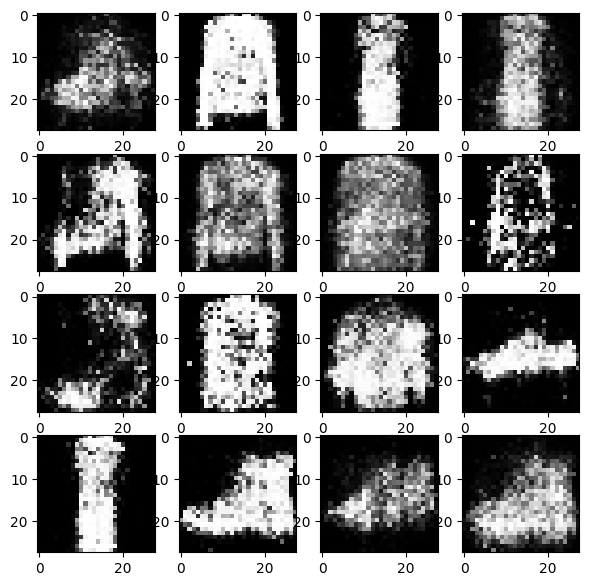

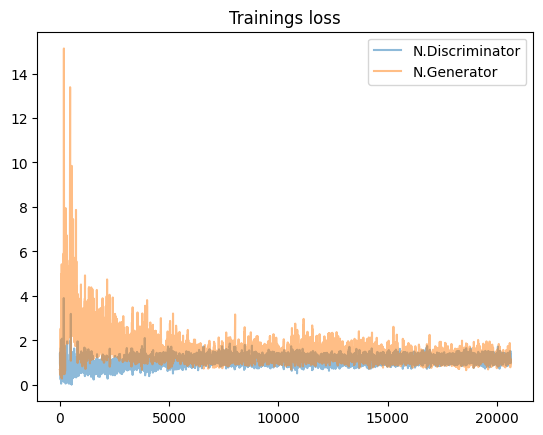

[23] -- discriminator_loss: 1.1278040409088135  -- generator_loss: 1.0791484117507935
[23] -- discriminator_loss: 1.1215871572494507  -- generator_loss: 1.0217394828796387
[23] -- discriminator_loss: 1.2448097467422485  -- generator_loss: 1.0821055173873901
[23] -- discriminator_loss: 1.1393202543258667  -- generator_loss: 1.0366941690444946
[23] -- discriminator_loss: 1.1573880910873413  -- generator_loss: 0.8819503784179688
[23] -- discriminator_loss: 1.3902556896209717  -- generator_loss: 1.0714170932769775
[23] -- discriminator_loss: 1.1191166639328003  -- generator_loss: 1.2002203464508057
[23] -- discriminator_loss: 1.1138492822647095  -- generator_loss: 1.3614697456359863
[23] -- discriminator_loss: 1.132709264755249  -- generator_loss: 1.1032462120056152
[23] -- discriminator_loss: 1.0723321437835693  -- generator_loss: 1.107151746749878
[23] -- discriminator_loss: 1.1555002927780151  -- generator_loss: 1.129130244255066
[23] -- discriminator_loss: 1.2086820602416992  -- genera

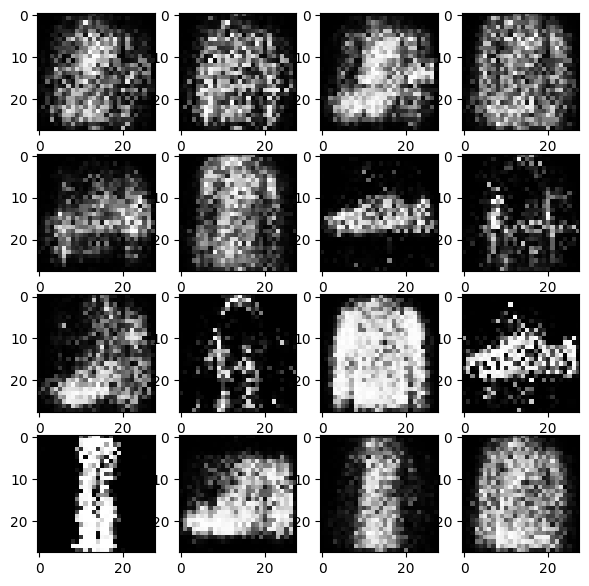

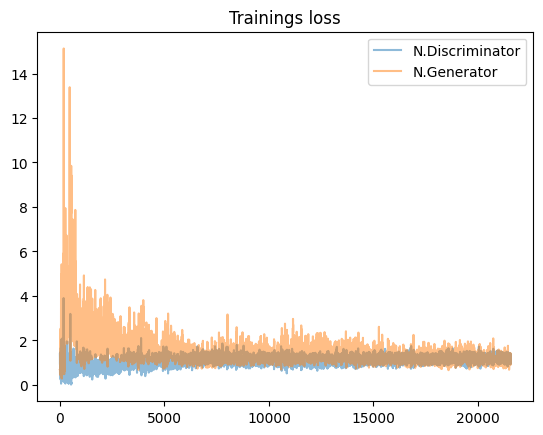

[24] -- discriminator_loss: 1.1771763563156128  -- generator_loss: 1.267220377922058
[24] -- discriminator_loss: 1.3602094650268555  -- generator_loss: 1.2338924407958984
[24] -- discriminator_loss: 1.0592989921569824  -- generator_loss: 1.088860034942627
[24] -- discriminator_loss: 1.1634814739227295  -- generator_loss: 1.3017295598983765
[24] -- discriminator_loss: 1.2436504364013672  -- generator_loss: 1.057451844215393
[24] -- discriminator_loss: 1.480244517326355  -- generator_loss: 1.154622197151184
[24] -- discriminator_loss: 1.1308783292770386  -- generator_loss: 1.1388399600982666
[24] -- discriminator_loss: 1.1494823694229126  -- generator_loss: 1.0128892660140991
[24] -- discriminator_loss: 1.1826145648956299  -- generator_loss: 1.2681609392166138
[24] -- discriminator_loss: 1.0664336681365967  -- generator_loss: 0.9498039484024048
[24] -- discriminator_loss: 1.4325231313705444  -- generator_loss: 0.8485626578330994
[24] -- discriminator_loss: 1.1898164749145508  -- generato

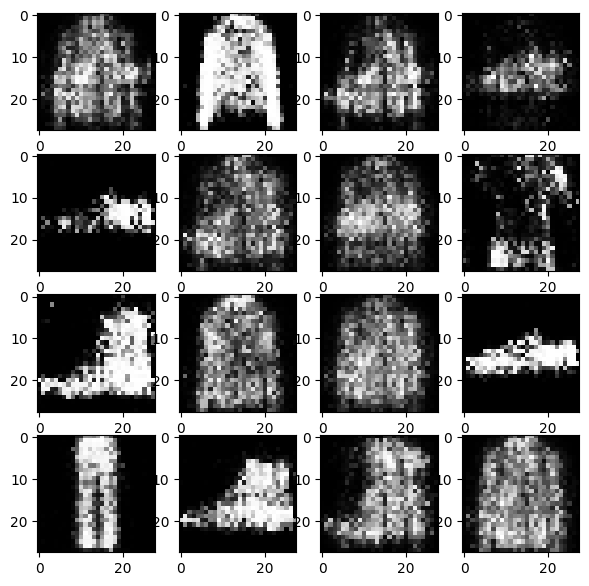

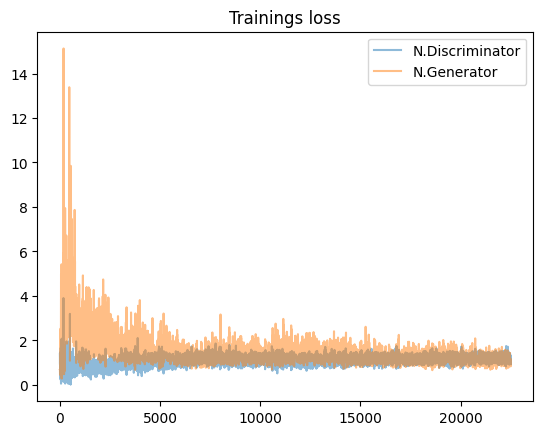

In [15]:
import pickle as pkl

max_epochs = 25

samples = list()
losses =  list()
d_loss_arr = list()
g_loss_arr = list()

Z = torch.from_numpy(np.random.uniform(-1, 1, size=(16, 100))).float()

D.train()
G.train()
                           
for epoch in range(1, max_epochs):
    for index, (img, l) in enumerate(train):
        img = img * 2 - 1 
        
        d_optimizer.zero_grad()
        
        fake_images = G(torch.from_numpy(np.random.uniform(-1, 1, size=(img.size(0), 100))).float())

        d_loss = (real_loss(D(img))) + fake_loss(D(fake_images))
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()

        fake_images = G(torch.from_numpy(np.random.uniform(-1, 1, size=(img.size(0), 100))).float())

        g_loss = real_loss(D(fake_images)) 
        
       
        g_loss.backward()
        g_optimizer.step()
        
        d_loss_arr.append(d_loss.item())
        g_loss_arr.append(g_loss.item())
        
      
        if index % 20 == 0 or index == 1:
            print(f'[{epoch}] -- discriminator_loss: {d_loss.item()}  -- generator_loss: {g_loss.item()}')
        

    losses.append((d_loss.item(), g_loss.item()))

    G.eval() 
    samples.append(G(Z))
    G.train()
    
    show_training_sample(samples)
    show_training_loss(d_loss_arr, g_loss_arr)